In [18]:

import numpy as np
import matplotlib.pyplot as plt
import statistics as st
import os
import pickle
import glob
%matplotlib inline

In [17]:
gain = lambda Wb,R,NPE,e:Wb/(NPE*e*R)
NumofPE=lambda Wb,R,g,e:Wb/(R*g*e)
def getValues(files,skip,nFiles=-1,findex=0,single=False,prnt=False):
    theone={}
    if(single):
        values={"time":np.array([]),"voltage":np.array([])}
        with open(files[findex]) as f:
            for i in range(0,skip):
                next(f)
            lines=f.readlines()
            for line in lines:
                splitline=line.split(",")
                values["time"]=np.append(values["time"],float(splitline[0]))
                values["voltage"]=np.append(values["voltage"],float(splitline[1]))
        theone[0]=values
        f.close()
        
    else:
        count=0
        for k in files:
            values={"time":np.array([]),"voltage":np.array([])}
            with open(k) as f:
                for i in range(0,skip):
                    next(f)
                lines=f.readlines()
                for line in lines:
                    splitline=line.split(",")
                    values["time"]=np.append(values["time"],float(splitline[0]))
                    values["voltage"]=np.append(values["voltage"],float(splitline[1]))
            theone[count]=values
            count+=1
            f.close()
            if(nFiles==count): 
                print(f"Analyzing Following Files ---> {k}")
                break

    return theone

def Histogram(data,xlabel,ylabel,title,figsize=(12,8),dpi=300,bins=3):
    plt.figure(figsize=figsize,dpi=dpi)
    plt.hist(data,bins=bins)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()
    
def WriteToFile(x,y,txtfile):
    with open(txtfile,"w") as f:
        for i in range(0,len(x)):
            s=str(x[i]) + " " +str(y[i]) +"\n"
            f.write(s)

def getArea(pmt,xlow,xhigh,minpulse=9999,gain=0,p=True):
 
    ### This is for removing DC offset
    MaskTime=pmt["time"]<=xlow
    DataNoOffset=pmt["voltage"]-st.mean(pmt["voltage"][MaskTime])
    datamin=np.min(DataNoOffset)
    if(datamin>=minpulse and minpulse!=9999): return -1
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.plot(pmt["time"],DataNoOffset,label="Signal DC-removed")
        plt.plot(pmt["time"],pmt["voltage"],label="Signal")
        plt.axvline(xlow)
        plt.axvline(xhigh)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.legend()
        plt.show()

    DataMask=np.where(np.logical_and(pmt["time"]>=xlow,pmt["time"]<=xhigh))
    x=pmt["time"][DataMask]
    y=DataNoOffset[DataMask]
    
    if(p):
        plt.figure(figsize=(12,8),dpi=300)
        plt.xlabel("Time (s)")
        plt.ylabel("Voltage (V)")
        plt.plot(x,y)
        plt.show()

    dt=pmt["time"][DataMask][1:]-pmt["time"][DataMask][:-1]
    area=abs(np.trapz(DataNoOffset[DataMask],dx=dt))
    if(gain):
        PE=NumofPE(area,50,gain,1.62e-19)
        
    
    return area,PE

def MultiAreaPE(data,xlow,xhigh,minpulse,g,p=False):
    area=np.array([])
    PE=np.array([])
    for key in data:
        result=getArea(data[key],xlow,xhigh,minpulse=minpulse,gain=g,p=p)
        if(result!=-1):
            area=np.append(area,result[0])
            PE=np.append(PE,result[1])
    values=np.array([area,PE])
    
    return values
def ListofFiles(path):
    Ch1filelist=[]
    Ch2filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
            #append the file name to the list
            if(file[:2]=="C2"):
                Ch2filelist.append(os.path.join(root,file))
            elif(file[:2]=="C1"):
                Ch1filelist.append(os.path.join(root,file))
    return Ch1filelist,Ch2filelist
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data

In [1]:
Gains=[3.8e6,2.5e6]

In [21]:
Ch1=ListofFiles("/media/argon/DATA/Ilker/CRAB/07.09.22/S2")[0]
Ch2=ListofFiles("/media/argon/DATA/Ilker/CRAB/07.09.22/S2")[1]


Analyzing Following Files ---> /media/argon/DATA/Ilker/CRAB/07.09.22/S2/1/C1s202477.csv


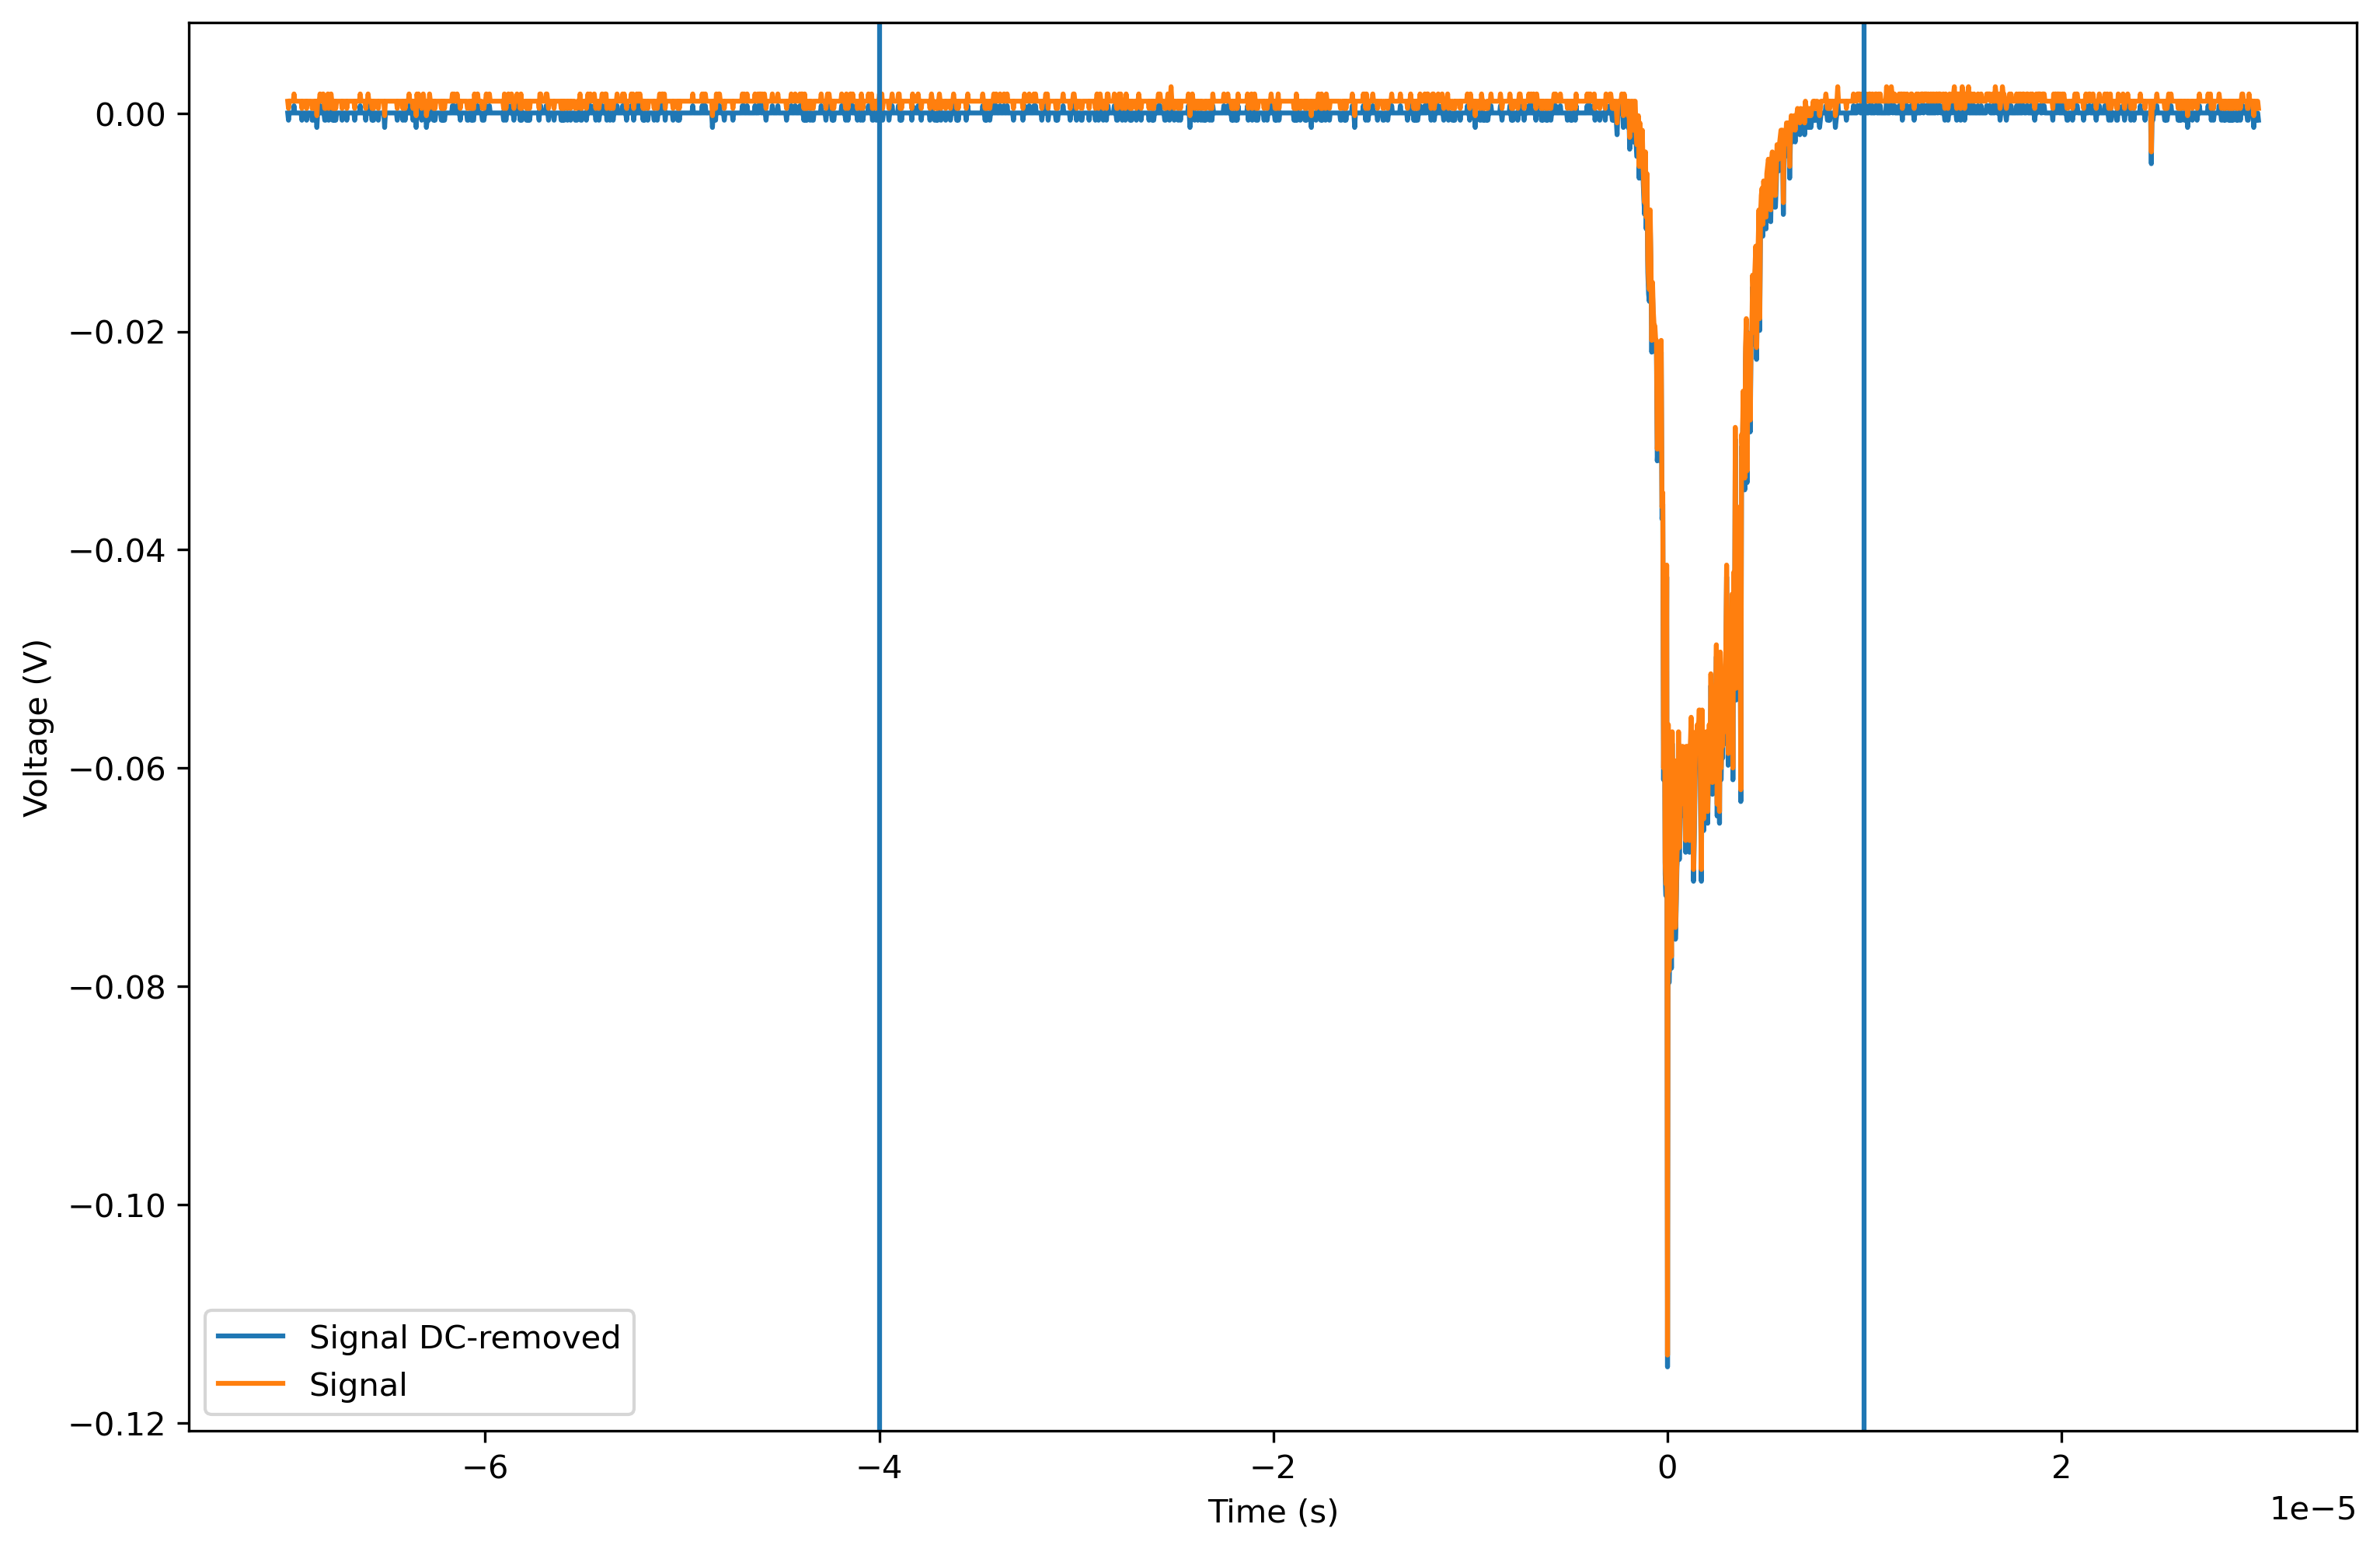

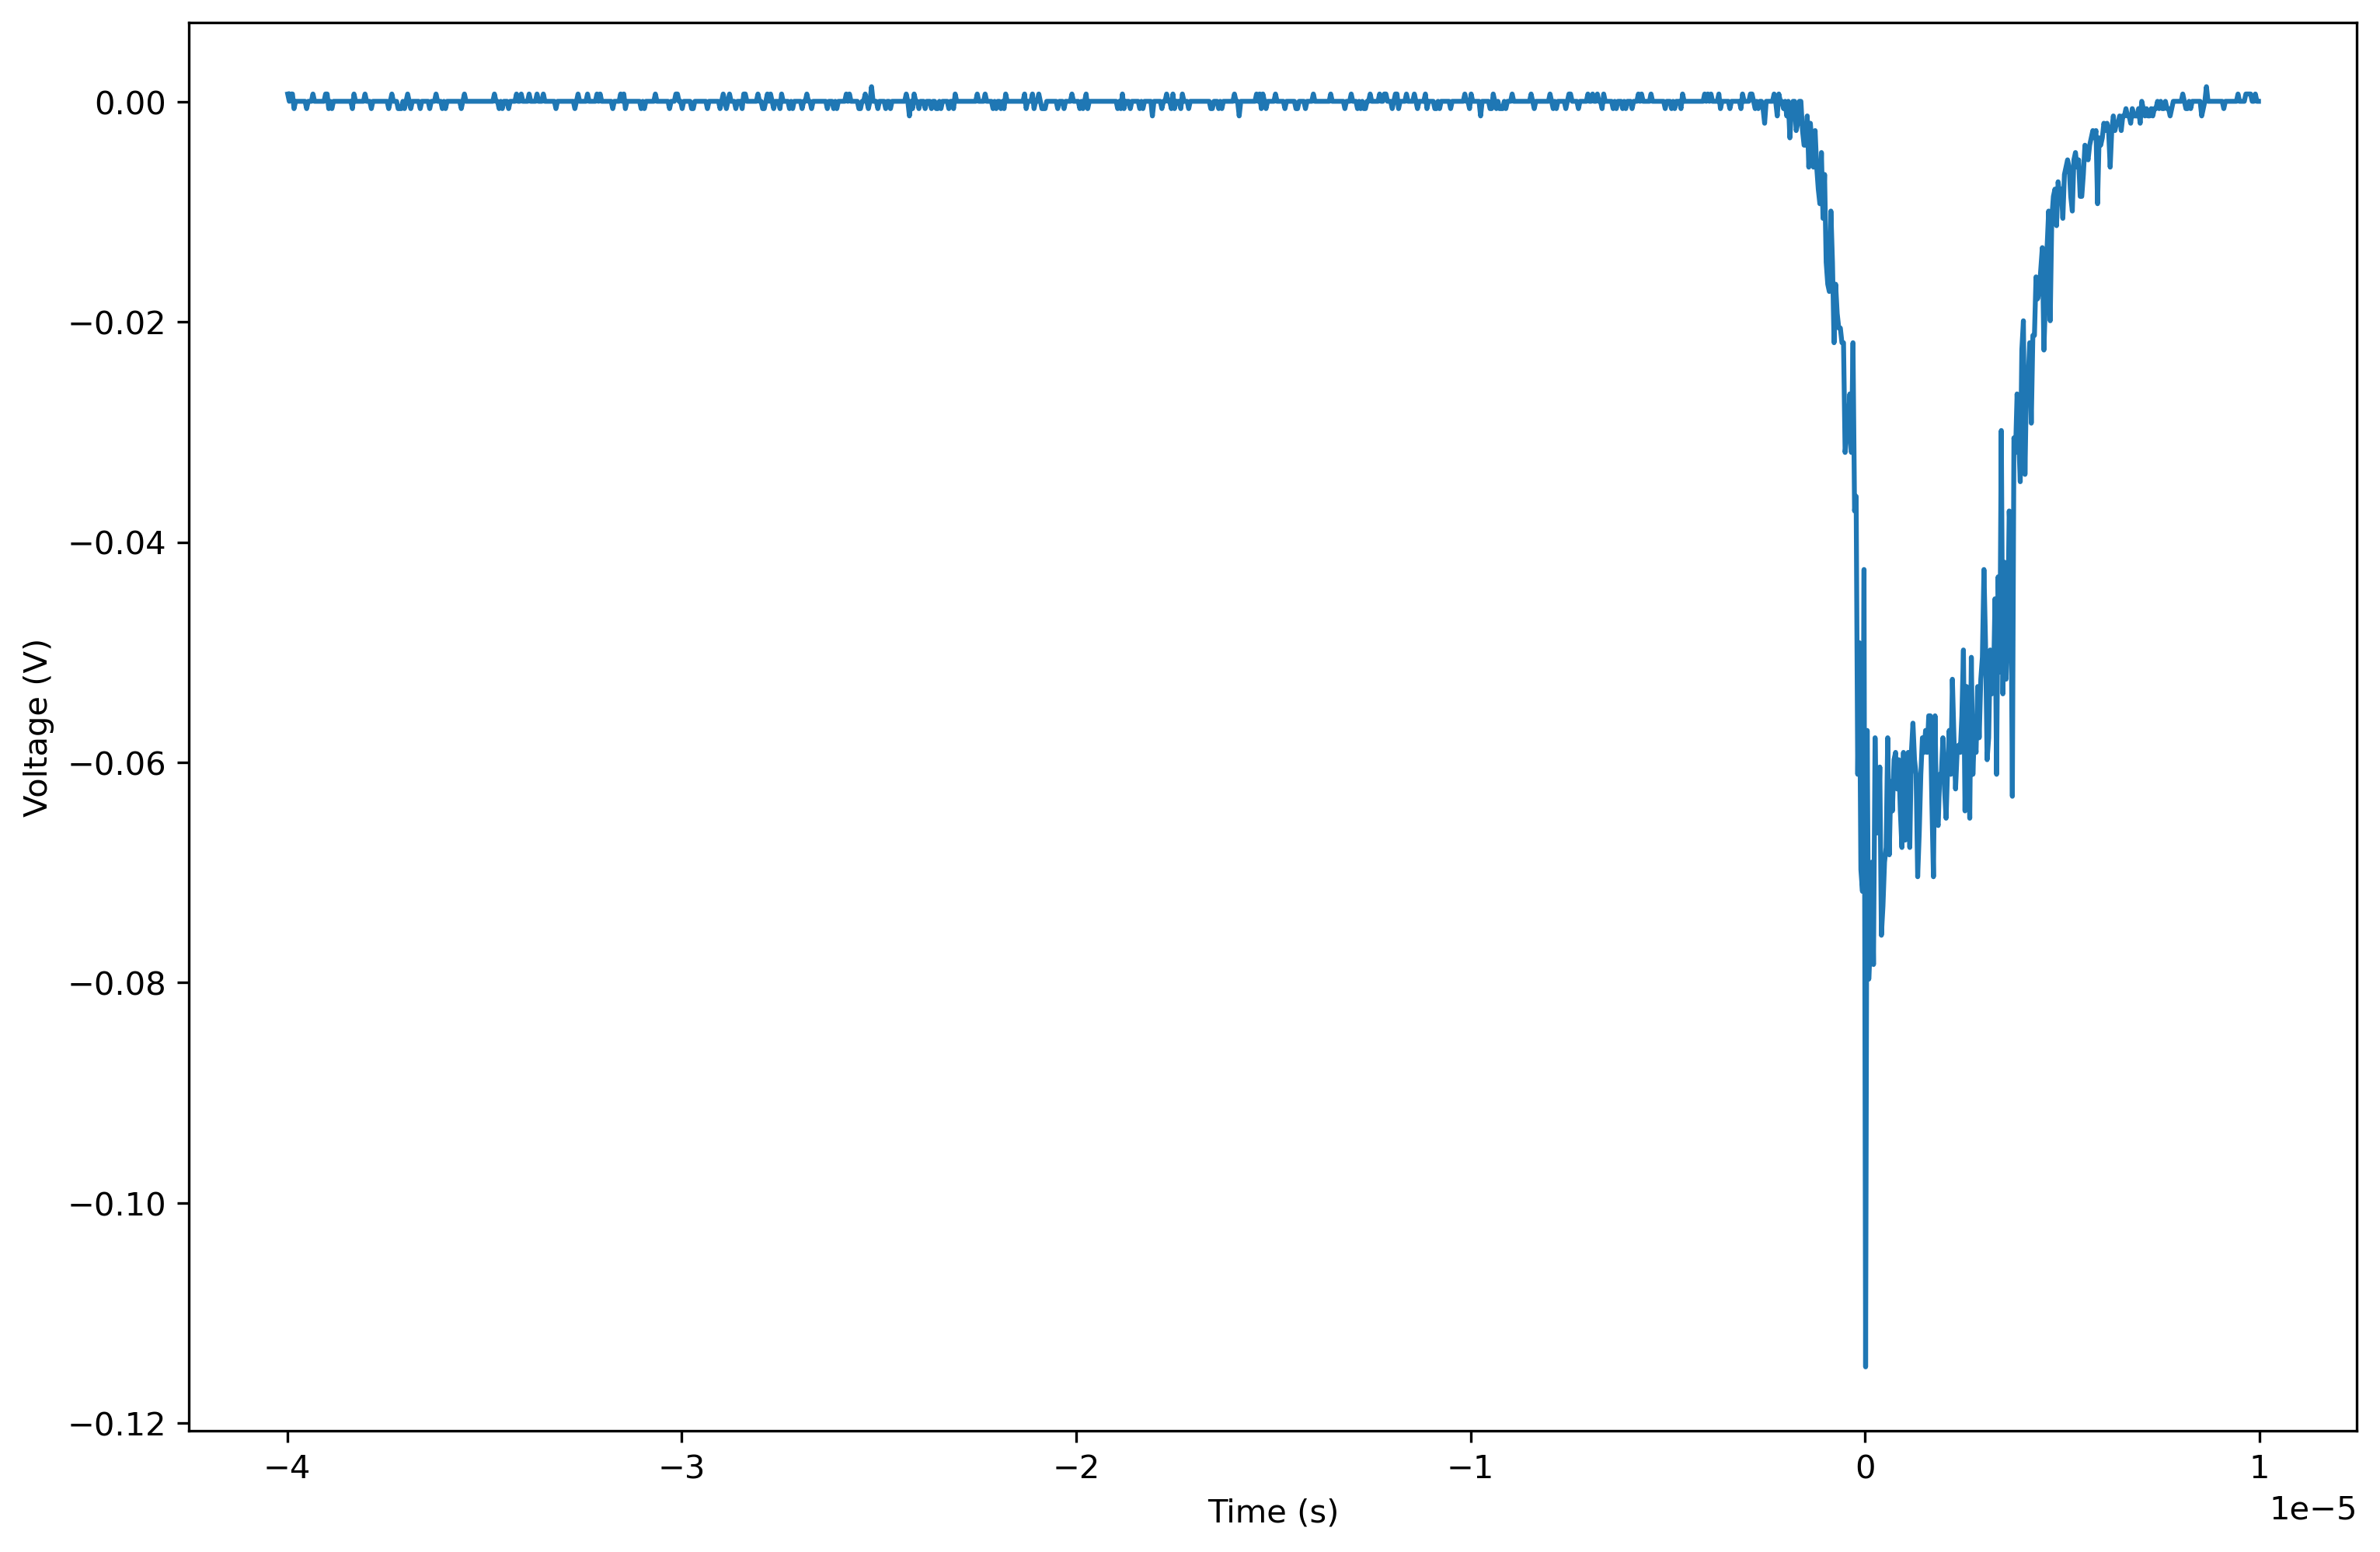

(2.9069962487154056e-07, 14355.53703069336)

In [5]:
Ch1data=getValues(Ch1,5,nFiles=20,single=False,prnt=False)
getArea(Ch1data[1],-4e-5,1e-5,minpulse=-0.003,gain=Gains[0],p=True)

In [6]:
if(not(os.path.exists("Ch1_data.p"))): 
    Ch1data=getValues(Ch1,5,single=False,prnt=False)
    PickleITDump(Ch1data,"Ch1_data.p")
else:
    Ch1data=PickleITRead("Ch1_data.p")
    
if(not(os.path.exists("Ch2_data.p"))):
    Ch2data=getValues(Ch2,5,single=False,prnt=False)
    PickleITDump(Ch2data,"Ch2_data.p")
else:
    Ch2data=PickleITRead("Ch2_data.p")


In [7]:
Ch1AreaPE=MultiAreaPE(Ch1data,-4e-5,1e-5,minpulse=9999,g=Gains[0],p=False)

Area mean = 5422.668715235023 stdev = 5998.564594394862


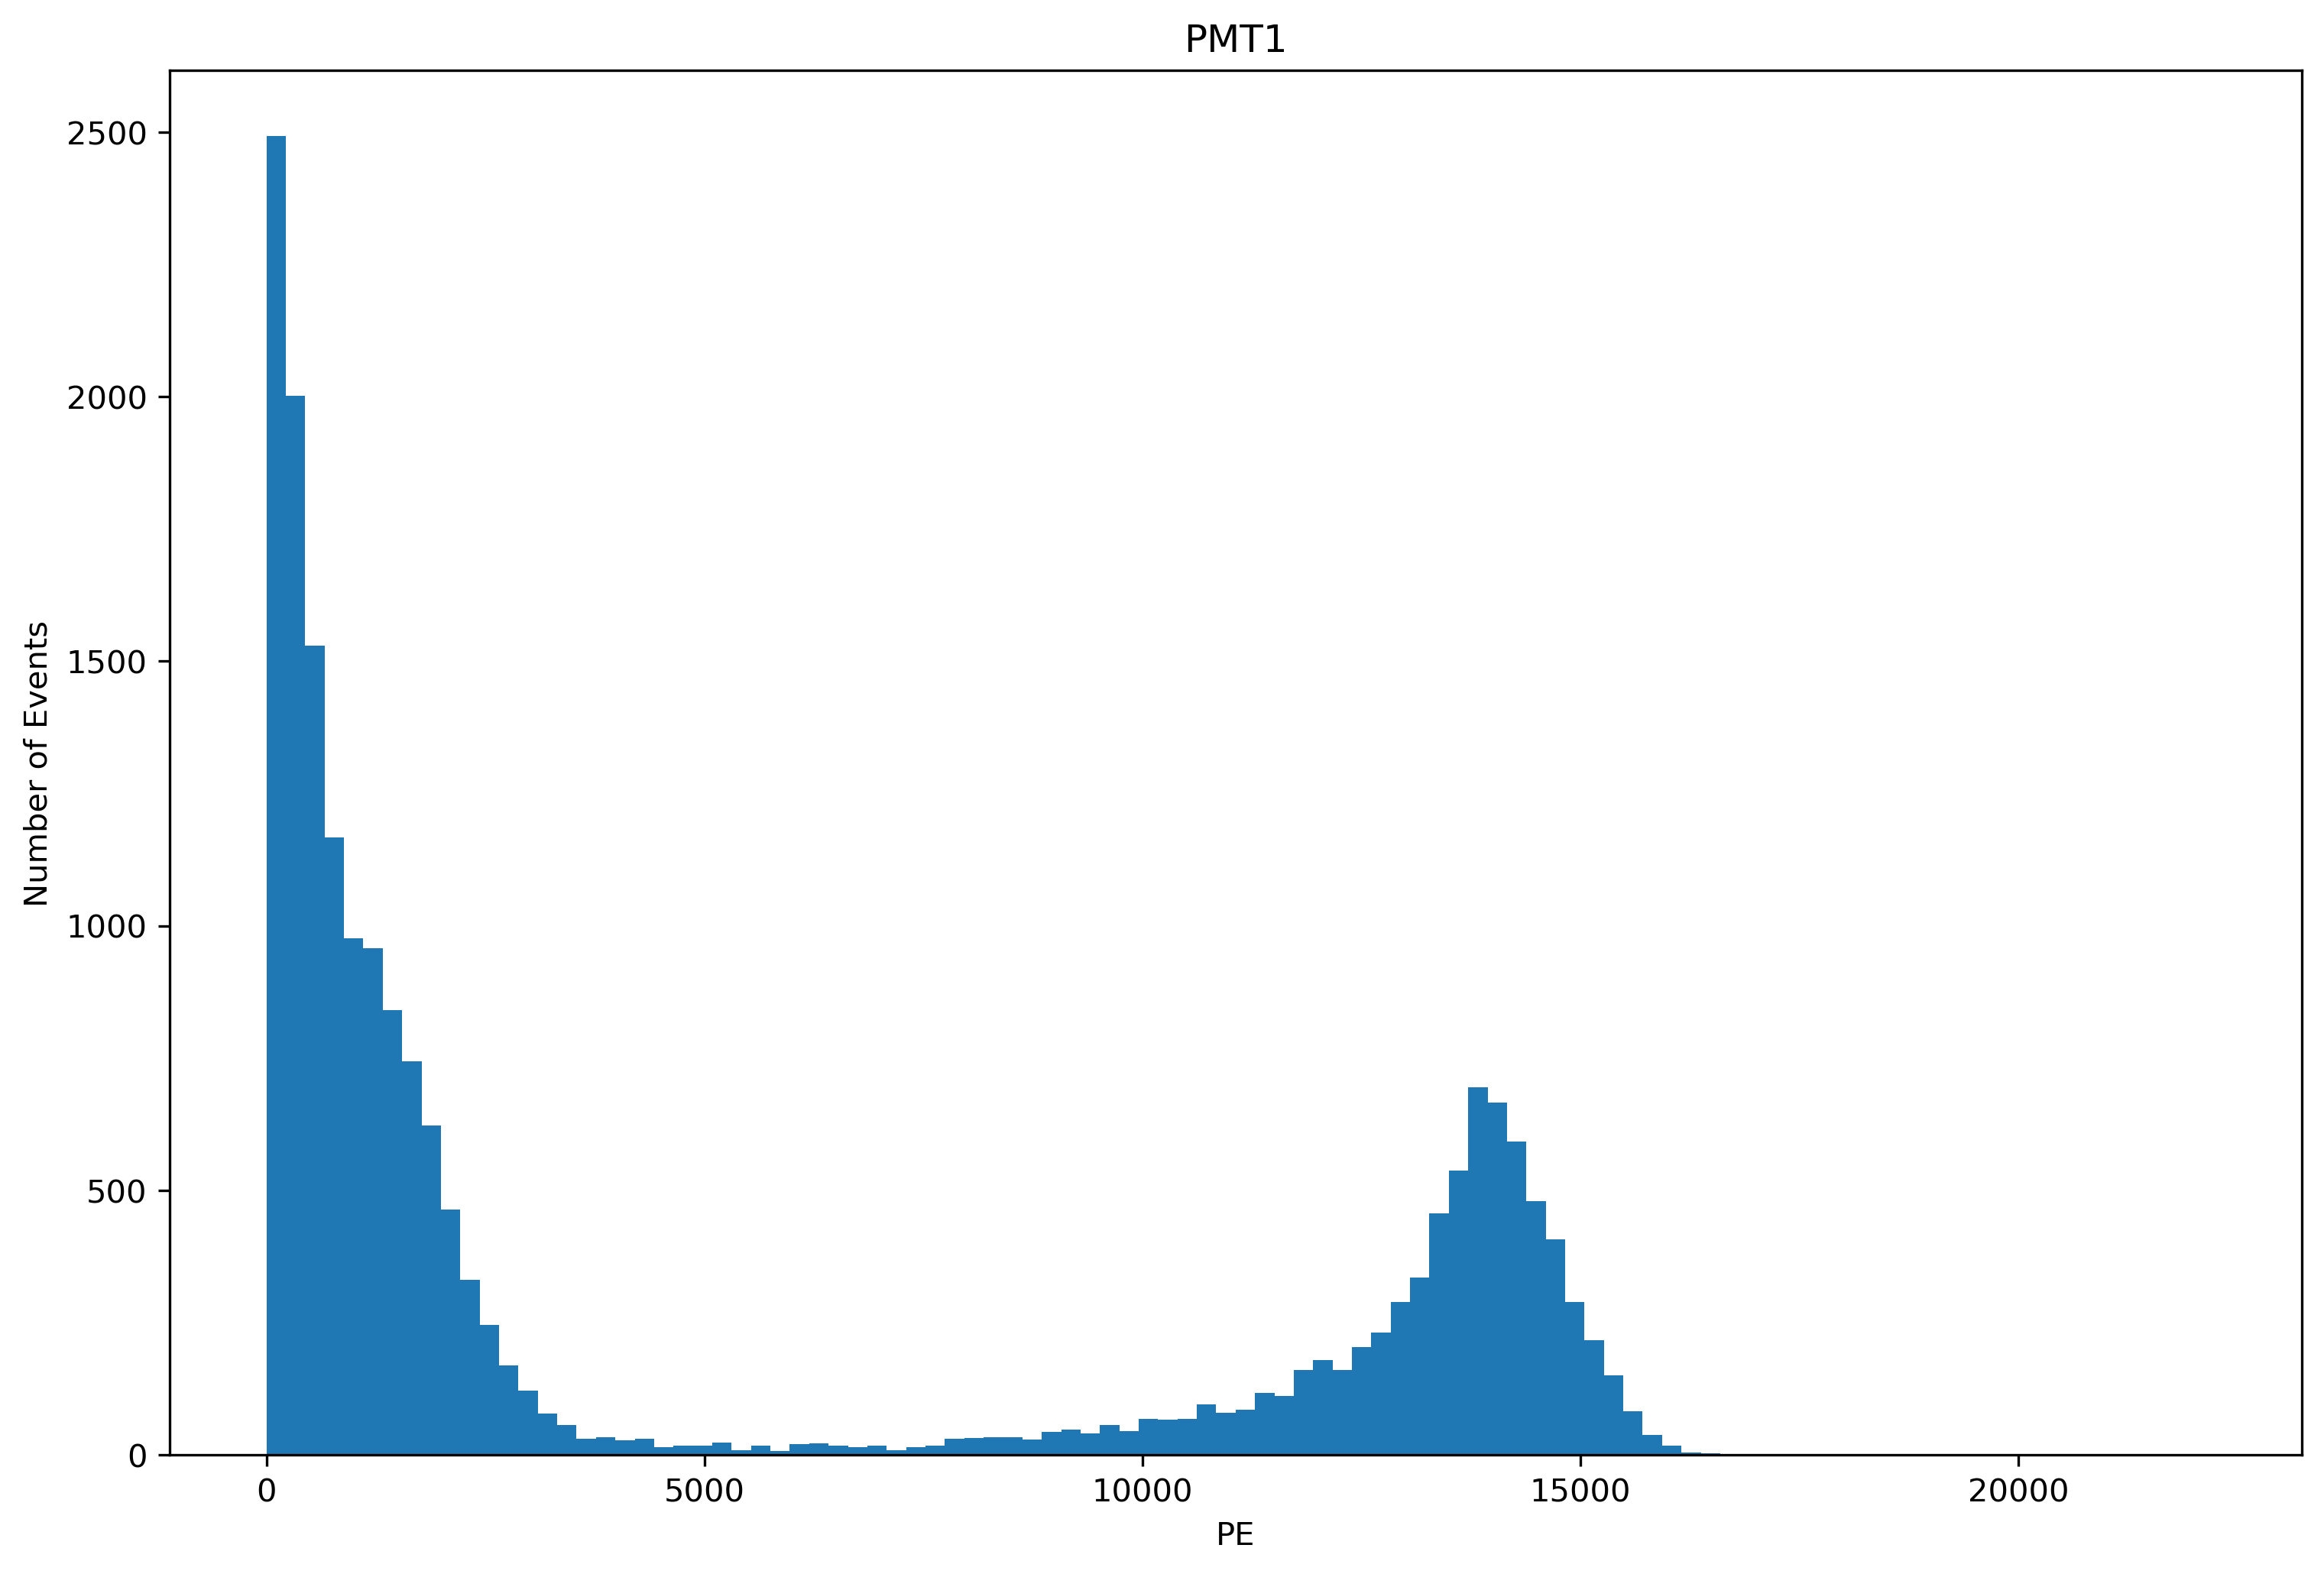

In [8]:
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(Ch1AreaPE[1],bins=100)
#plt.semilogy()
mean=st.mean(Ch1AreaPE[1])
stdev=st.stdev(Ch1AreaPE[1])

print(f"Area mean = {mean} stdev = {stdev}")

In [9]:
Ch2AreaPE=MultiAreaPE(Ch2data,-4e-5,1e-5,minpulse=9999,g=Gains[1],p=False)

Area mean = 434.77277101341264 stdev = 512.9074595539695


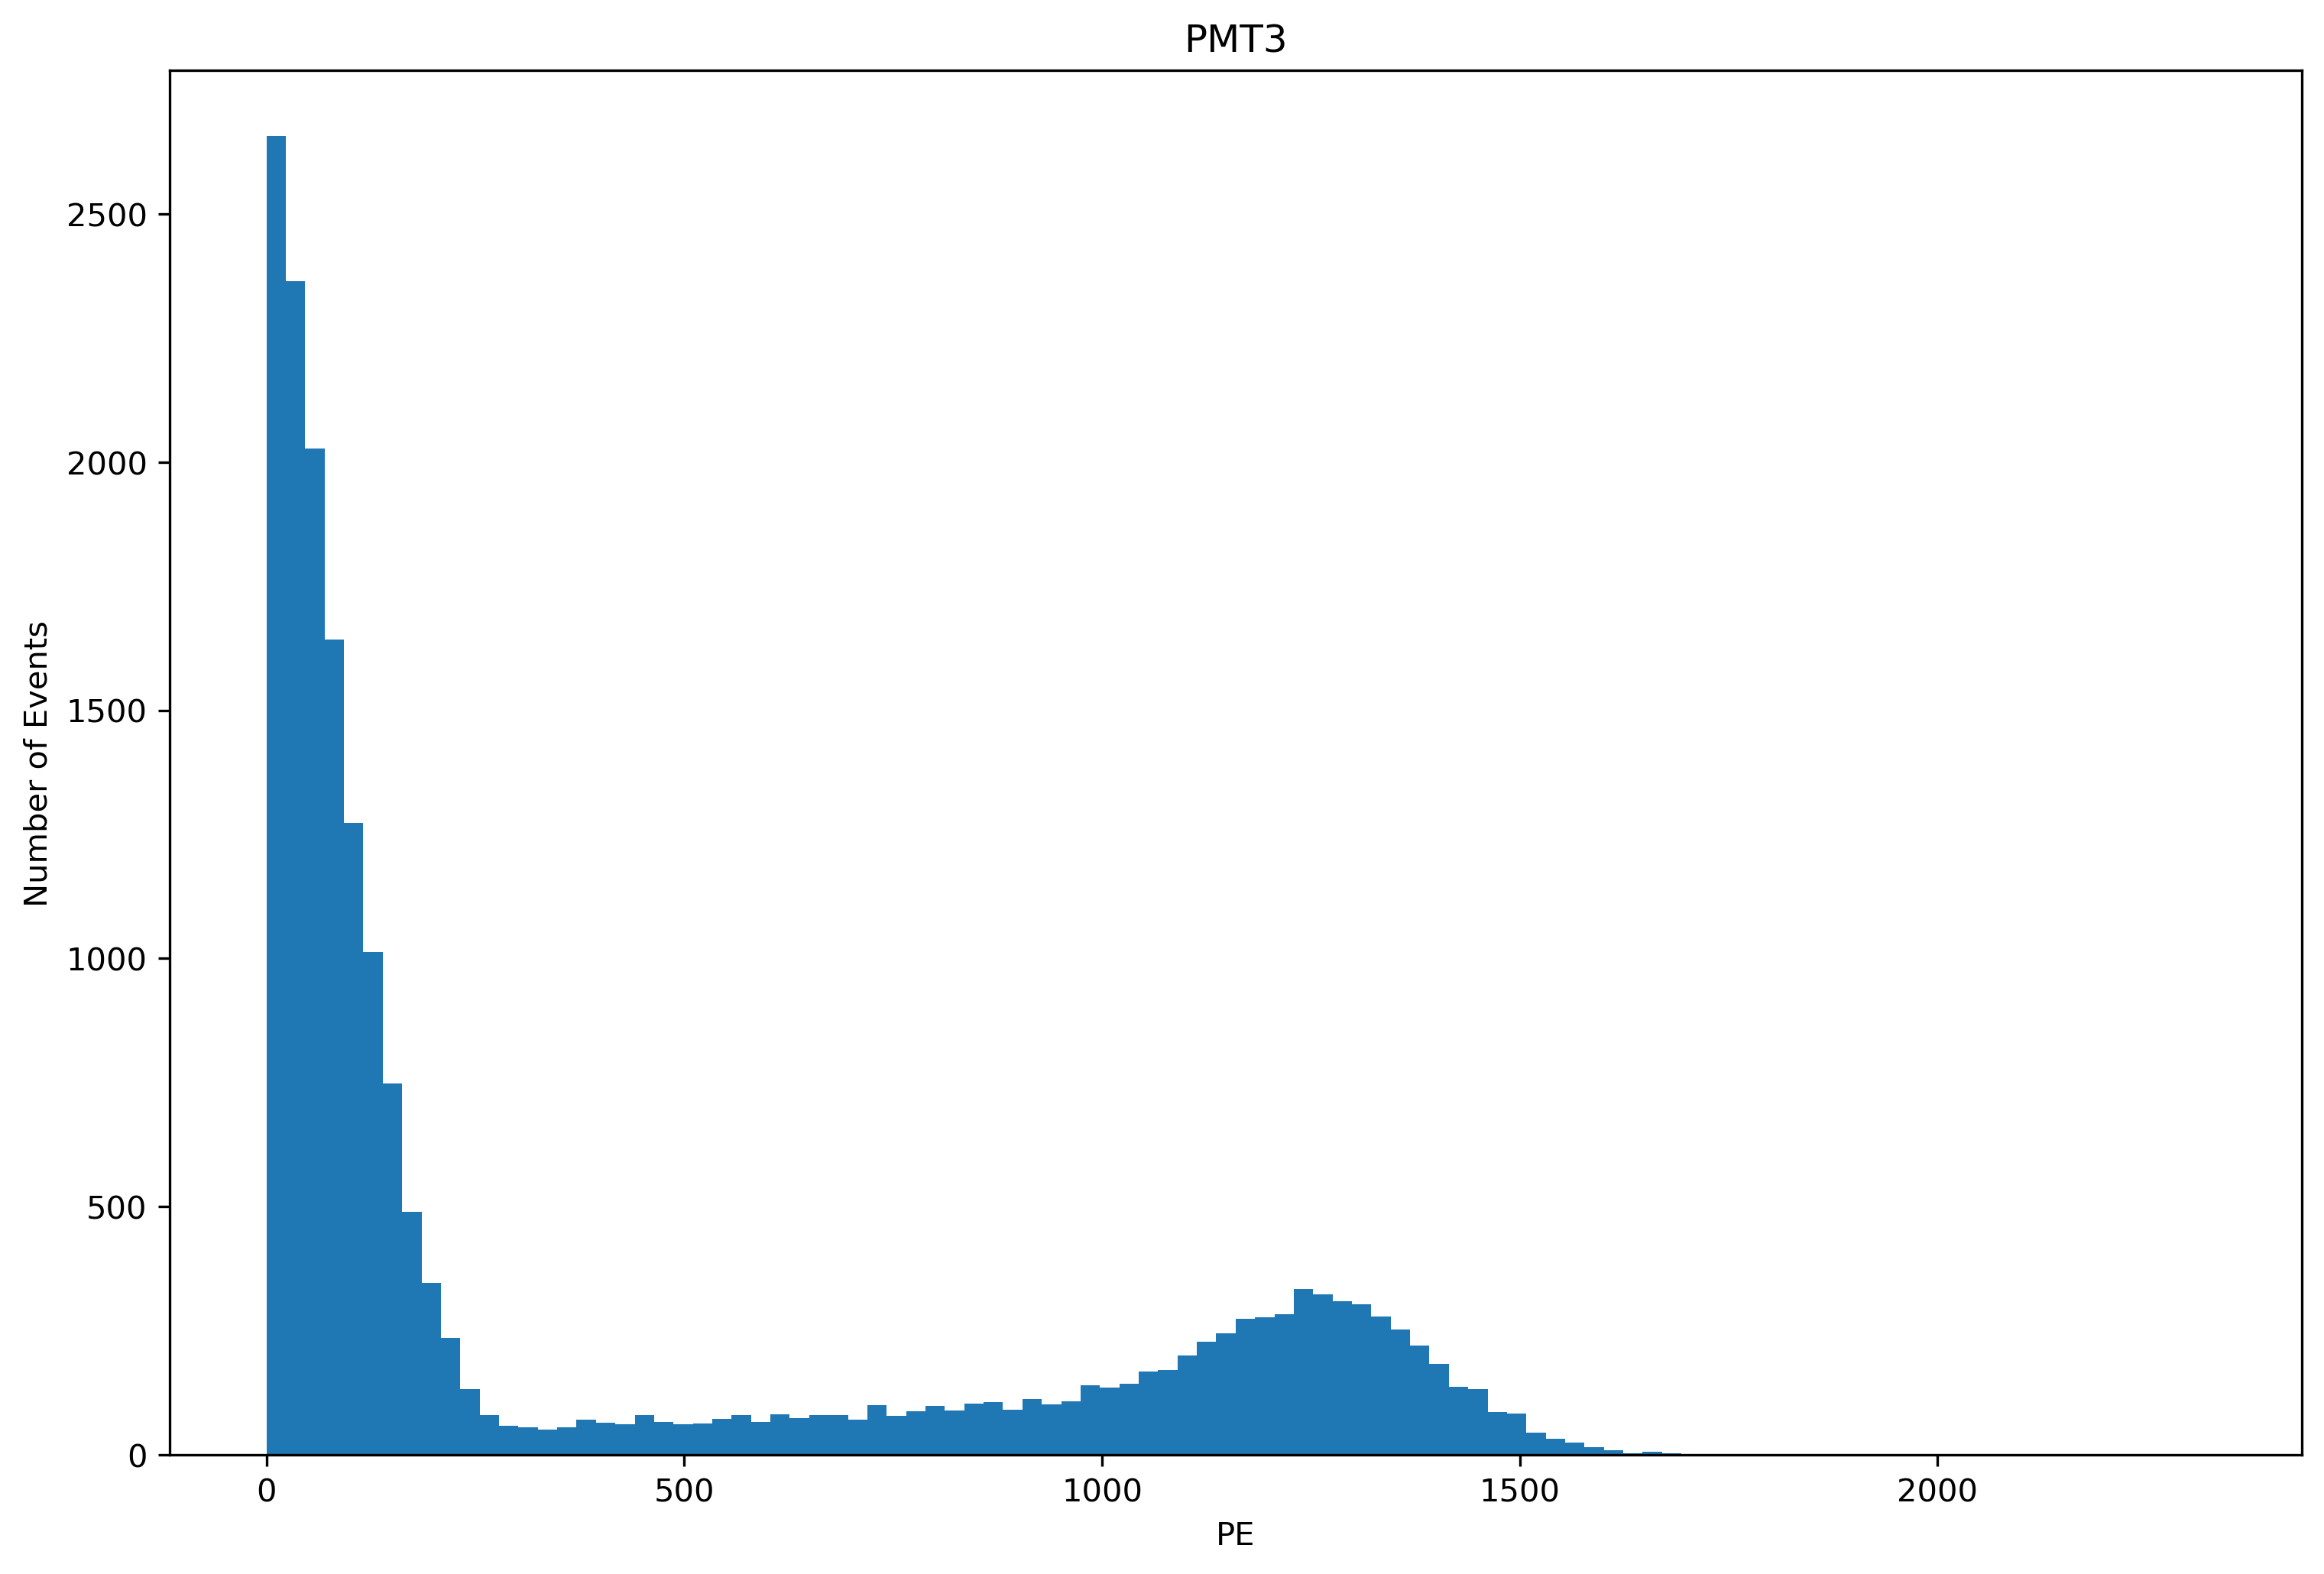

In [10]:
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(Ch2AreaPE[1],bins=100)

#plt.semilogy()
mean=st.mean(Ch2AreaPE[1])
stdev=st.stdev(Ch2AreaPE[1])
print(f"Area mean = {mean} stdev = {stdev}")

In [11]:
###################### Run 2 ###################################
Run1_Ch1=ListofFiles("/media/argon/DATA/Ilker/CRAB/07.08.22/S2")[0]
Run1_Ch2=ListofFiles("/media/argon/DATA/Ilker/CRAB/07.08.22/S2")[1]

In [12]:
Run2QuickCh1=getValues(Run1_Ch1,5,nFiles=20,single=False,prnt=False)
getArea(Run2QuickCh1[1],-4e-5,1e-5,minpulse=-0.003,gain=Gains[0],p=True)

Analyzing Following Files ---> /media/argon/DATA/Ilker/CRAB/07.08.22/S2/1/C1s2-bothPMTs01047.csv


-1

In [13]:
if(not(os.path.exists("Run1_Ch1_S2data.p"))): 
    Run1_Ch1data=getValues(Run1_Ch1,5,single=False,prnt=False)
    PickleITDump(Run1_Ch1data,"Run1_Ch1_S2data.p")
else:
    Run1_Ch1data=PickleITRead("Run1_Ch1_S2data.p")
    
if(not(os.path.exists("Run1_Ch2_S2data.p"))):
    Run1_Ch2data=getValues(Run1_Ch2,5,single=False,prnt=False)
    PickleITDump(Run1_Ch2data,"Run1_Ch2_S2data.p")
else:
    Run1_Ch2data=PickleITRead("Run1_Ch2_S2data.p")

Area mean = 7683.395162859757 stdev = 4991.72055158795


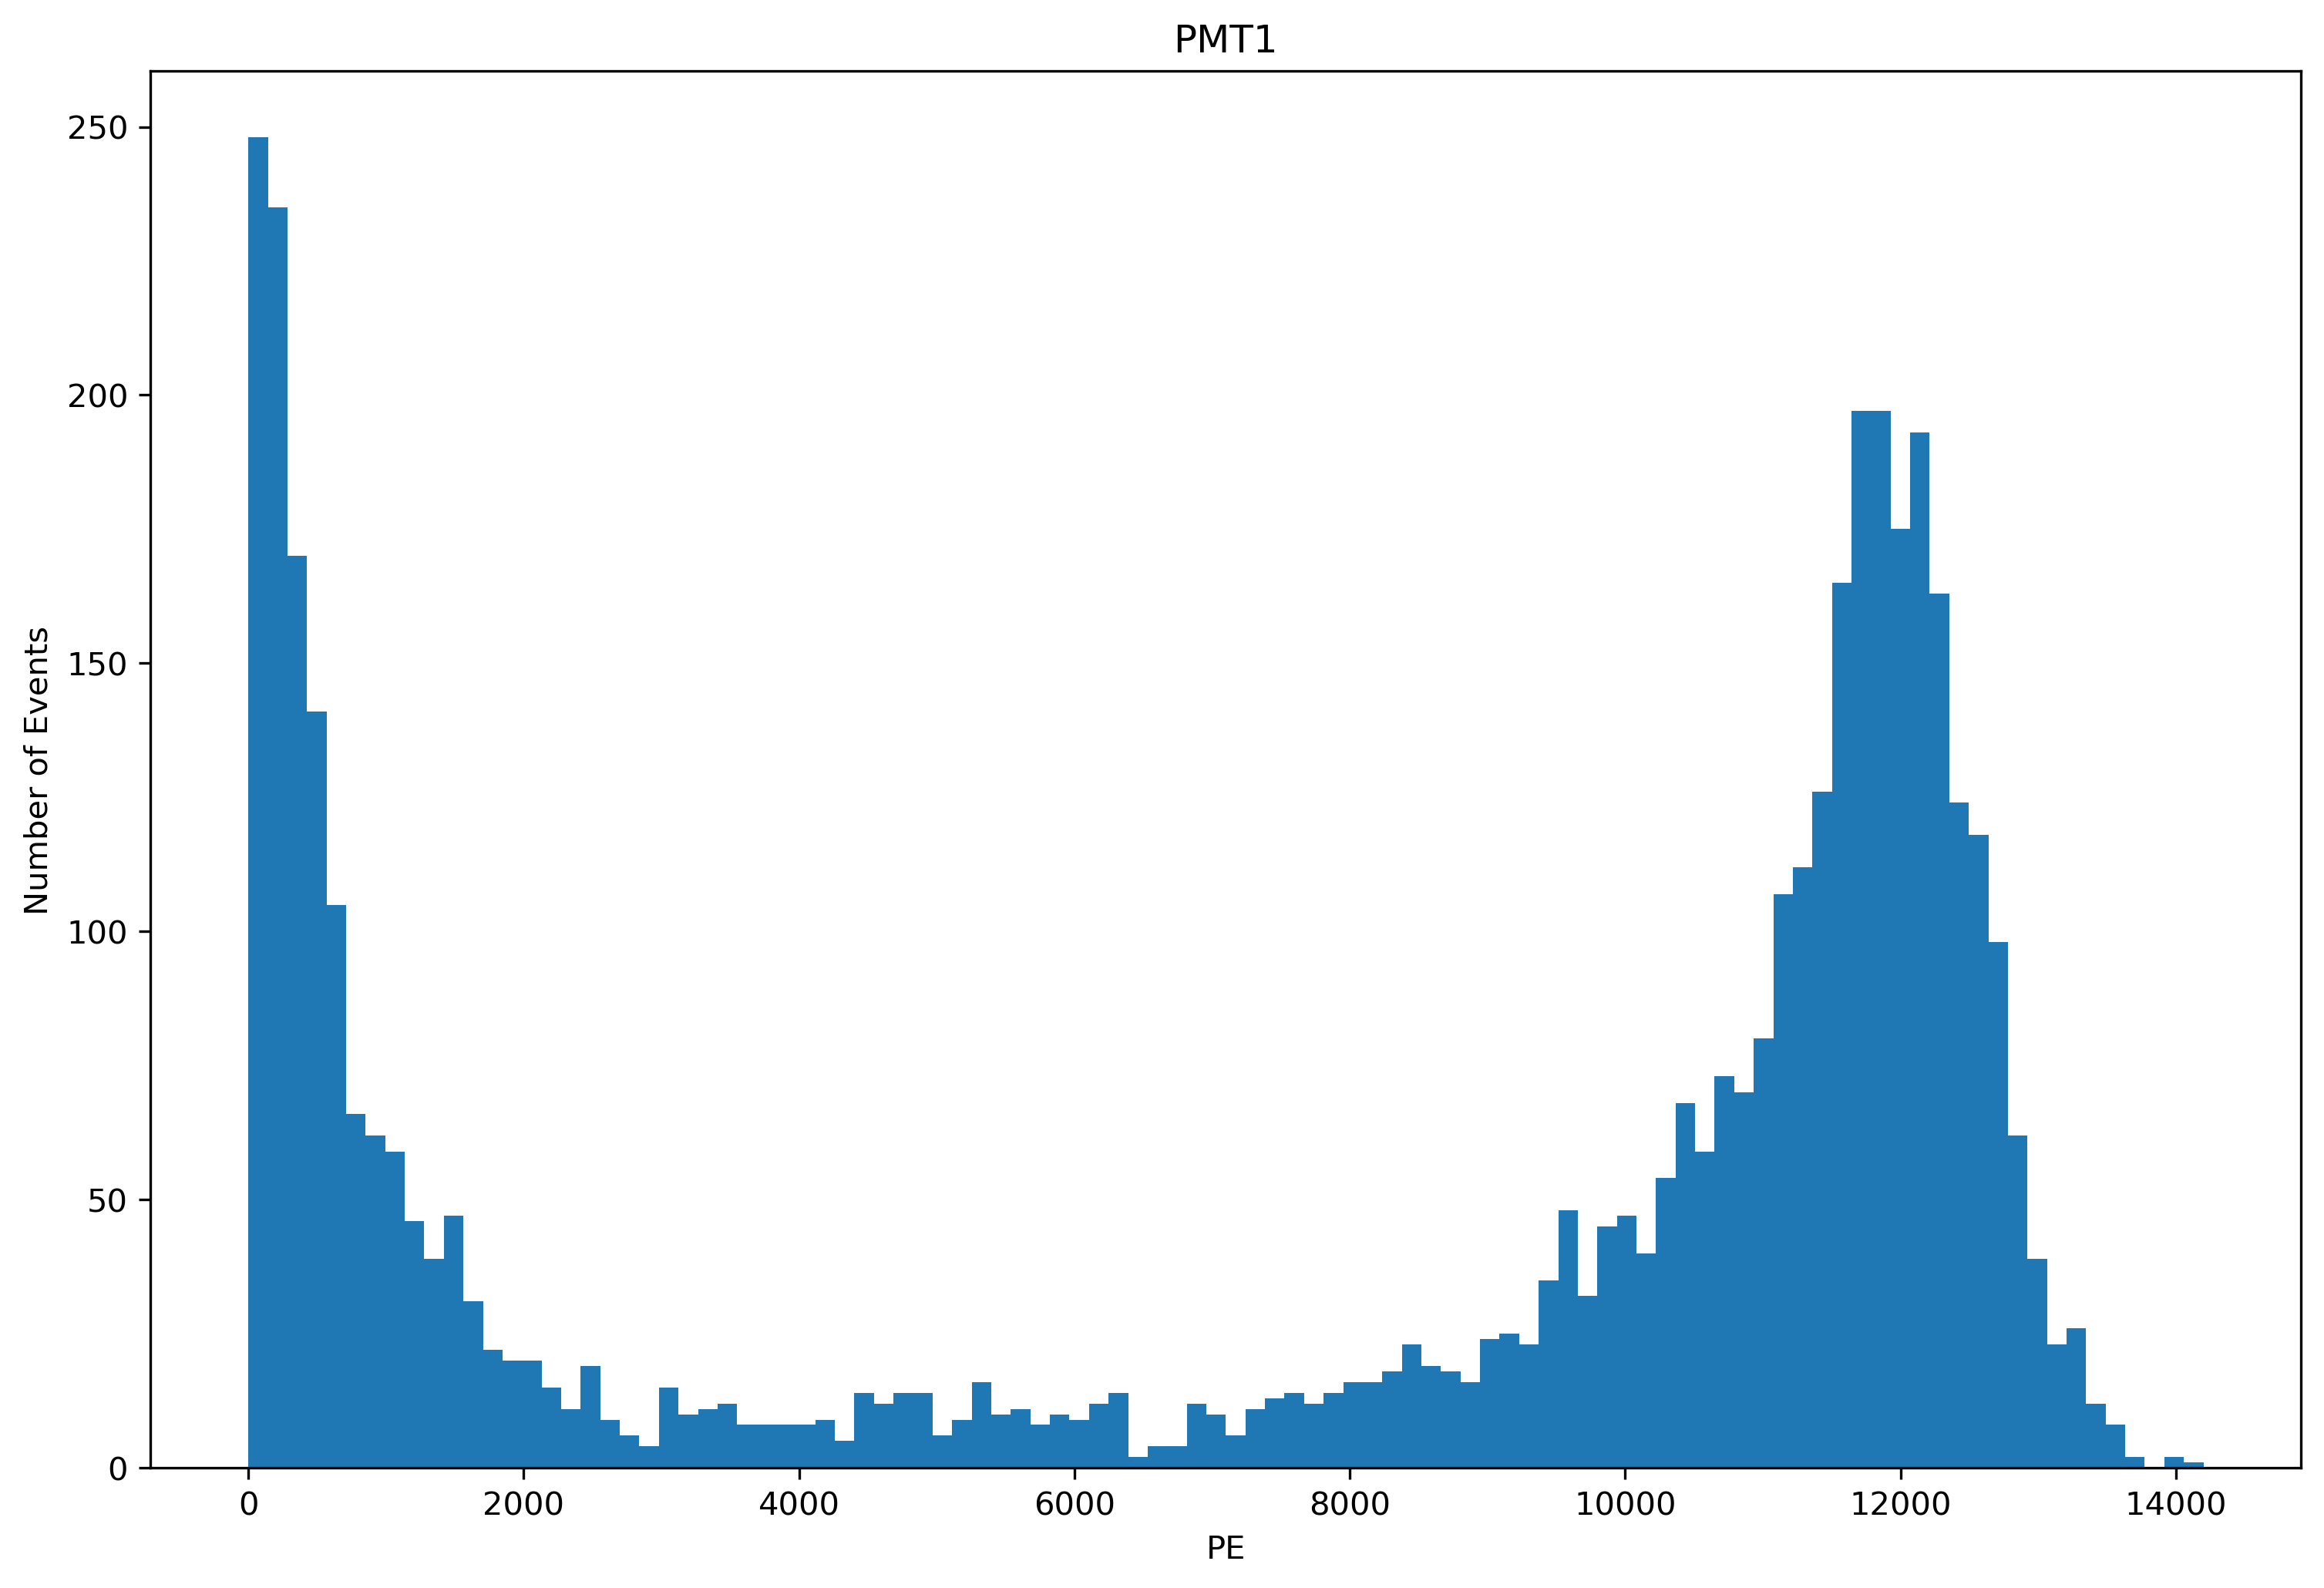

In [14]:
Run1_Ch1AreaPE=MultiAreaPE(Run1_Ch1data,-4e-5,1e-5,minpulse=9999,g=Gains[0],p=False)
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT1")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(Run1_Ch1AreaPE[1],bins=100)

#plt.semilogy()
mean=st.mean(Run1_Ch1AreaPE[1])
stdev=st.stdev(Run1_Ch1AreaPE[1])
print(f"Area mean = {mean} stdev = {stdev}")

Area mean = 612.5289832424688 stdev = 410.1960887006739


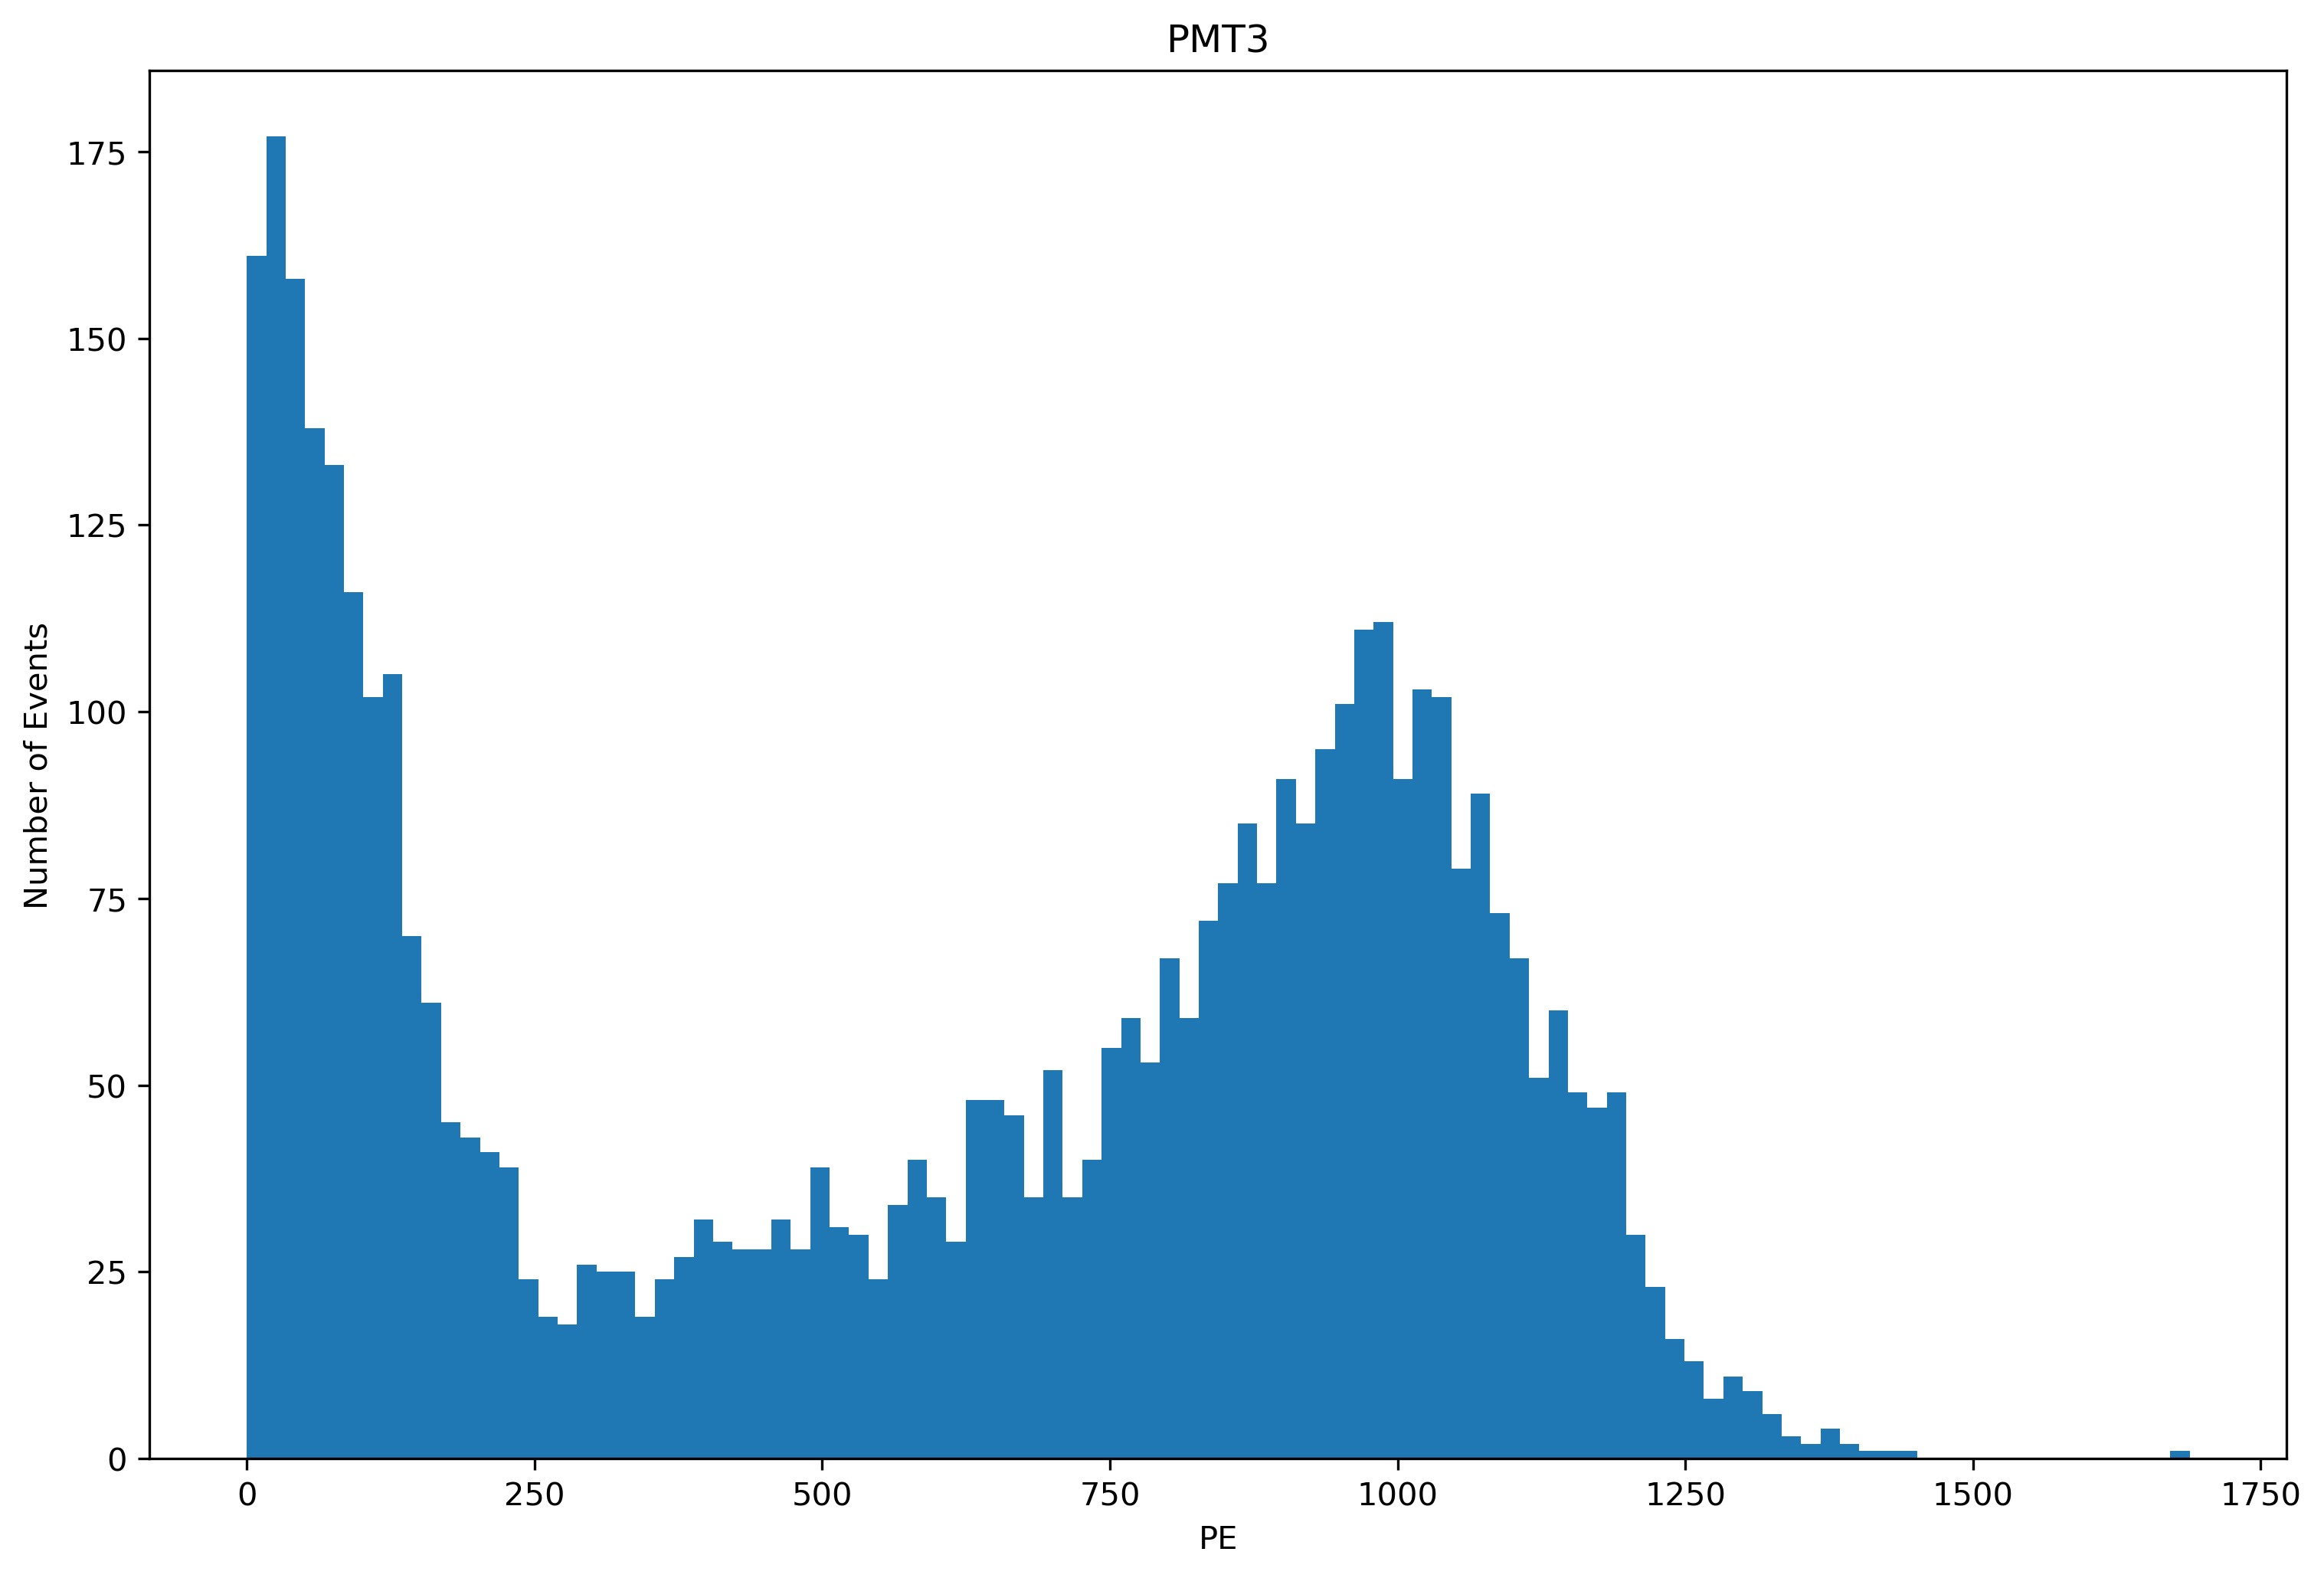

In [15]:
Run1_Ch2AreaPE=MultiAreaPE(Run1_Ch2data,-4e-5,1e-5,minpulse=9999,g=Gains[0],p=False)
plt.figure(figsize=(12,8),dpi=300)
plt.title("PMT3")
plt.ylabel("Number of Events")
plt.xlabel("PE")
plt.hist(Run1_Ch2AreaPE[1],bins=100)

#plt.semilogy()
mean=st.mean(Run1_Ch2AreaPE[1])
stdev=st.stdev(Run1_Ch2AreaPE[1])
print(f"Area mean = {mean} stdev = {stdev}")